# Meeting Notes
## June 24, 2021 Meeting: 
### Meeting Notes:
* The autoencoder seems to be learning the test data really well but it is not able to apply that to the validation data (Overlearning)
* There are a few ways that I could try to fix this: 
** See if the data that I'm inputting is somehow weird looking (I don't think so)
** Set the AE to have a lower learning rate
** Try different activation functions (Tanh, LeakyRelu, etc.)
** Get rid of outliers
** Change size of the AE (Different amount of layers, neurons etc.)
 ### To Do: 
 * Try out different activation functions
 * Check data to make sure it isn't weird (Data is not weird)
 * Try different learning rate
 * Annotate Eric Wolf's Thesis and try to go through the same alterations that he did. 

In [2]:
import numpy as np 
import uproot 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import functions as fun
import sys

def load_cms_data(filename="open_cms_data.root"):
    """This function loads events data from open CMS root files"""

    # The object returned by uproot.open represents a TDirectory inside the file (/).
    # We are interested in the Events branch
    events_tree = uproot.open(filename)['Events']

    # events_tree.show(name_width=100, typename_width=100)

    # The Collection we want is: recoPFJets_ak5PFJets__RECO

    recoPFJets = events_tree['recoPFJets_ak5PFJets__RECO.']['recoPFJets_ak5PFJets__RECO.obj']
    #recoPFJets.show(name_width=100, typename_width=100)

    prefix = 'recoPFJets_ak5PFJets__RECO.obj.'
    # Store the 27 variables we are interested in to a pandas dataframe
    dataframe = recoPFJets.arrays(
        [prefix + 'pt_', prefix + 'eta_', prefix + 'phi_', prefix + 'mass_', prefix + 'vertex_.fCoordinates.fX',
         prefix + 'vertex_.fCoordinates.fY', prefix + 'vertex_.fCoordinates.fZ', prefix + 'mJetArea', prefix + 'mPileupEnergy',
         prefix + 'm_specific.mChargedHadronEnergy', prefix + 'm_specific.mNeutralHadronEnergy',
         prefix + 'm_specific.mPhotonEnergy', prefix + 'm_specific.mElectronEnergy',
         prefix + 'm_specific.mMuonEnergy', prefix + 'm_specific.mHFHadronEnergy', prefix + 'm_specific.mHFEMEnergy',
         prefix + 'm_specific.mChargedHadronMultiplicity', prefix + 'm_specific.mNeutralHadronMultiplicity',
         prefix + 'm_specific.mPhotonMultiplicity', prefix + 'm_specific.mElectronMultiplicity', prefix + 'm_specific.mMuonMultiplicity',
         prefix + 'm_specific.mHFHadronMultiplicity', prefix + 'm_specific.mHFEMMultiplicity',
         prefix + 'm_specific.mChargedEmEnergy', prefix + 'm_specific.mChargedMuEnergy', prefix + 'm_specific.mNeutralEmEnergy',
         prefix + 'm_specific.mChargedMultiplicity', prefix + 'm_specific.mNeutralMultiplicity'],       library="pd")

    prefix2 = 'ak5PFJets.'
    # Rename the column names to be shorter
    dataframe.columns = [prefix2 + 'pt_', prefix2 + 'eta_', prefix2 + 'phi_', prefix2 + 'mass_',
                         prefix2 + 'fX', prefix2 + 'fY', prefix2 + 'fZ', prefix2 + 'mJetArea', prefix2 + 'mPileupEnergy',
                         prefix2 + 'mChargedHadronEnergy', prefix2 + 'mNeutralHadronEnergy', prefix2 + 'mPhotonEnergy',
                         prefix2 + 'mElectronEnergy', prefix2 + 'mMuonEnergy', prefix2 + 'mHFHadronEnergy',
                         prefix2 + 'mHFEMEnergy', prefix2 + 'mChargedHadronMultiplicity', prefix2 + 'mNeutralHadronMultiplicity',
                         prefix2 + 'mPhotonMultiplicity', prefix2 + 'mElectronMultiplicity', prefix2 + 'mMuonMultiplicity',
                         prefix2 + 'mHFHadronMultiplicity', prefix2 + 'mHFEMMultiplicity', prefix2 + 'mChargedEmEnergy',
                         prefix2 + 'mChargedMuEnergy', prefix2 + 'mNeutralEmEnergy', prefix2 + 'mChargedMultiplicity',
                         prefix2 + 'mNeutralMultiplicity']


    print("\nDataframe:")
    print(dataframe.head()) #Only first 5 rows of df
    dataframe.to_csv('27D_opensCMS_data.csv')
    return dataframe




In [3]:
fourvector = load_cms_data()
#Cutting off data so that only 4-vector data is left
fourvector = fourvector.iloc[:,0:4]
print("Altered df")
fourvector.info()
#Normalize Data
fourvector[fourvector.columns] = StandardScaler().fit_transform(fourvector)
print(fourvector.head())
#Dropping the value with pT > 20
fourvector.drop(fourvector[fourvector['ak5PFJets.pt_']>400].index, inplace=True)




Dataframe:
                ak5PFJets.pt_  ak5PFJets.eta_  ak5PFJets.phi_  \
entry subentry                                                  
0     0             97.293968       -1.046758       -1.378504   
      1             86.607674       -1.797043        2.055401   
      2             40.815239       -1.400267        1.314550   
      3             25.064486       -2.256013       -2.359081   
      4             24.530922       -2.289618        0.647938   

                ak5PFJets.mass_  ak5PFJets.fX  ak5PFJets.fY  ak5PFJets.fZ  \
entry subentry                                                              
0     0               16.212225           0.0           0.0           0.0   
      1               16.508511           0.0           0.0           0.0   
      2               11.218516           0.0           0.0           0.0   
      3                7.330747           0.0           0.0           0.0   
      4                7.968142           0.0           0.0           

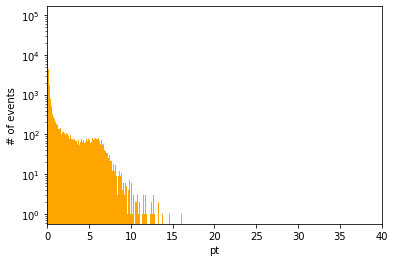

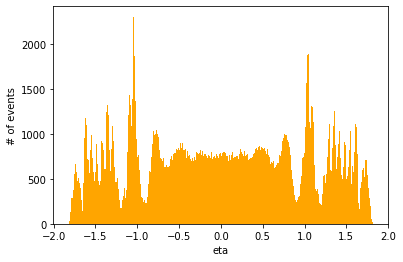

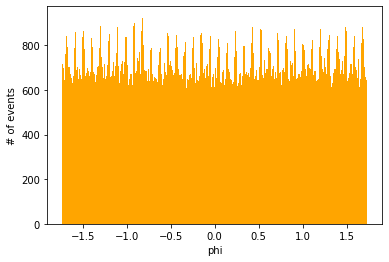

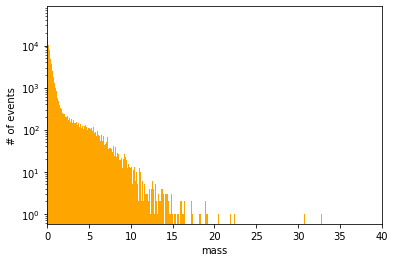

In [4]:
#Plotting data before autoencoder

n_bins = 100
variable_list = ["pt", "eta", "phi", "mass"]
branches=["ak5PFJets.pt_","ak5PFJets.eta_","ak5PFJets.phi_", "ak5PFJets.mass_"]

n_bins = 1000
#mass and pt are in logscale
for kk in range(0,4):
    if kk ==0 or kk==3:
        plt.yscale("log")
        plt.xlim(right=40)
        
    n_hist_data, bin_edges, _ = plt.hist(fourvector[branches[kk]], color='orange', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk])
    plt.ylabel('# of events')
    plt.savefig("./Original Data(4Vector)")
    plt.show()


In [5]:
#Creating datasets for AE
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

fourvector = shuffle(fourvector)
train_x, test_x = train_test_split(fourvector, test_size=0.2, random_state=1)
train_y = train_x
test_y = test_x
print('Train data shape: ')
print(train_x.shape)
print('Test data shape: ')
print(test_x.shape)

data = torch.tensor(test_x.values, dtype=torch.float)

train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

Train data shape: 
(573156, 4)
Test data shape: 
(143289, 4)


In [6]:
bs = 1024 #Initially set at 256, Trying 500, 1000, 100
##512 is the first to not give spikes
# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs)
dls = core.DataLoaders(train_dl, valid_dl)



In [7]:
#Building AE
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200,100)
        self.en3 = nn.Linear(100,50)
        self.en4 = nn.Linear(50,3)
        self.de1 = nn.Linear(3, 50)
        self.de2 = nn.Linear(50, 100)
        self.de3 = nn.Linear(100,200)
        self.de4 = nn.Linear(200, n_features)
        self.relu = False
        if self.relu:
            self.leakyRelu = nn.LeakyReLU()
        else:
            self.tanh = nn.Tanh()
        
    def encode(self, x):
        if self.relu:
            return self.en4(self.leakyRelu(self.en3(self.leakyRelu(self.en2(self.leakyRelu(self.en1(x)))))))
        else:
            return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        if self.relu:
            return self.de4(self.leakyRelu(self.de3(self.leakyRelu(self.de2(self.leakyRelu(self.de1(self.leakyRelu(x))))))))
        else:
            return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return '4-200-100-50-3'


model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

In [8]:

from fastai.metrics import mse, partial
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.test_utils import *

loss_function = nn.MSELoss()
weight_decay = 1e-6

recorder = learner.Recorder()

learn = learner.Learner(dls, model=model, wd=weight_decay, loss_func=loss_function, cbs=recorder)


In [9]:
#Training the AE
import time
from fastai.callback import schedule


start = time.perf_counter() # Starts timer
# train our autoencoder for 100 epochs
learn.fit_one_cycle(1, 0.00108)
end = time.perf_counter() # Ends timer
delta_t = end - start
print(delta_t)



epoch,train_loss,valid_loss,time
0,0.016246,0.016753,00:13
0,0.016246,0.016753,00:13


13.561785844998667


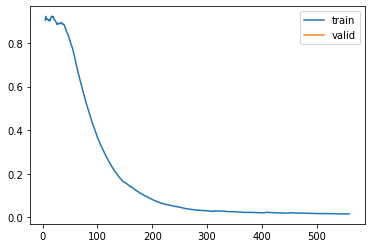

In [10]:
recorder.plot_loss()
  

In [11]:
learn.validate()


(#1) [0.01675264909863472]

In [12]:
#ResidualsPlot




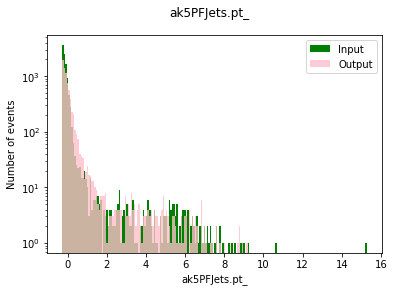

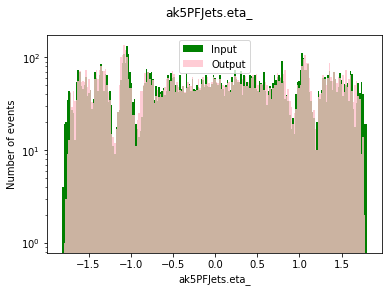

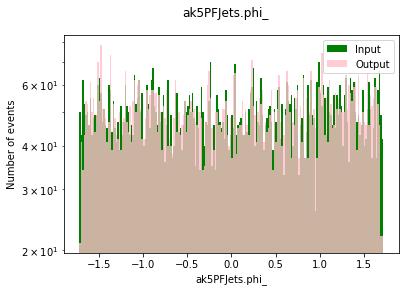

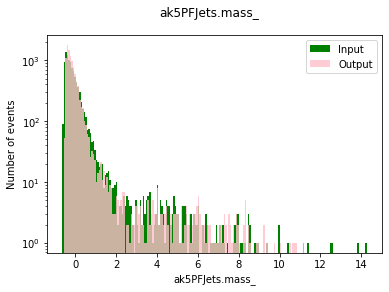

In [13]:
#Graphing the final results
import os

plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['pink', 'green']
markers = ['*', 's']

model.to('cpu')
save = True
idxs = (0, 10000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values, dtype=torch.float)

pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test_x.columns)
pred_df = pd.DataFrame(pred, columns=test_x.columns)

alph = 0.8
n_bins = 200
save_dir = '.'

for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test_x.columns[kk])
    plt.xlabel(test_x.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test_x.columns[kk]+'.png'))
    plt.legend()

In [14]:
def sep_list(inceptionList):
    list1 = []
    list2 = []
    list3 = []
    list4 = []
    for i in inceptionList:
        list1.append(i[0])
        list2.append(i[1])
        list3.append(i[2])
        list4.append(i[3])
    return list1, list2, list3, list4

,ak5PFJets.pt_,ak5PFJets.eta_,ak5PFJets.phi_,ak5PFJets.mass_,residual_pt,residual_eta,residual_phi,residual_mass
0,-0.198133,1.299191,-1.549799,-0.298651,0.020486,0.002952,0.022197,0.017902
1,-0.239573,0.199863,-1.720053,-0.378764,0.048916,0.029903,0.024806,0.022624
2,0.006924,-1.033798,-0.888096,0.083591,0.013740,0.023058,0.003885,0.058311
3,-0.246172,0.180571,-1.655057,-0.461421,0.086636,0.026357,0.031314,0.051415
4,-0.070145,-0.811748,-1.198573,0.042225,0.036743,0.027491,0.002022,0.082462
...,...,...,...,...,...,...,...,...
143284,0.418451,-0.237334,1.673685,0.533520,0.073718,0.013178,0.020573,0.079721
143285,-0.083787,0.440593,0.571191,0.111853,0.095104,0.013117,0.012691,0.087553
143286,-0.170062,-0.668527,1.703550,-0.199729,0.007243,0.031864,0.009359,0.005916
143287,-0.087379,-0.667371,1.028222,0.050081,0.071026,0.001010,0.004496,0.060441


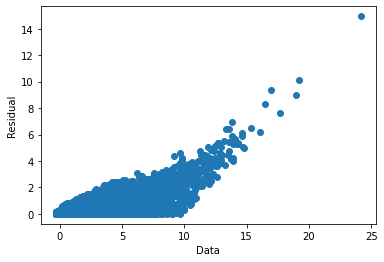

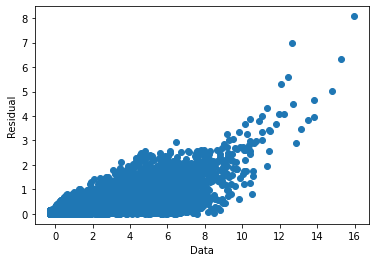

This is the train data [[-6.6509143e-02 -9.7130960e-01 -1.5305424e+00 -3.4133874e-02]
 [ 5.4716453e-02 -1.3408616e+00  1.0634842e+00  2.6599312e-01]
 [-1.6547054e-01  4.8219076e-01 -2.0272338e-01 -2.4768057e-01]
 ...
 [-6.2442258e-02  2.3325889e-01  1.4673092e+00  4.4408027e-04]
 [ 1.5452108e-01 -2.0280728e-01  1.0574096e+00  4.9106088e-01]
 [-1.9779445e-01  8.1839567e-01 -1.2345645e+00 -2.8242299e-01]]


In [15]:
#Plotting the residuals
#This allows the data to be input into the model
test_data = torch.tensor(test_x.values, dtype=torch.float)
train_data = torch.tensor(train_x.values, dtype=torch.float)
#This lets the model predict
prediction_test = model(test_data)
prediction_train = model(train_data)
#This creates a numpy array out of the data
prediction_test = prediction_test.detach().numpy()
test_data = test_data.detach().numpy()
prediction_train = prediction_train.detach().numpy()
train_data = train_data.detach().numpy()


#pred_test_df = (prediction_test, columns=test_x.columns)
#pred_train_df = (prediction_train, columns=test_x.columns)

test_data_df = pd.DataFrame(test_data, columns=test_x.columns)
train_data_df = pd.DataFrame(train_data, columns=test_x.columns)

#

### Calculate the residuals 
residual_test = np.absolute(test_data - prediction_test)
residual_train = np.absolute(train_data - prediction_train)
residual_test_pt, residual_test_eta, residual_test_phi, residual_test_mass = sep_list(residual_test)
residual_train_pt, residual_train_eta, residual_train_phi, residual_train_mass = sep_list(residual_train)
#Adding residuals to dataframe
test_data_df['residual_pt'] = residual_test_pt
test_data_df['residual_eta'] = residual_test_eta
test_data_df['residual_phi'] = residual_test_phi
test_data_df['residual_mass'] = residual_test_mass

train_data_df['residual_pt'] = residual_train_pt
train_data_df['residual_eta'] = residual_train_eta
train_data_df['residual_phi'] = residual_train_phi
train_data_df['residual_mass'] = residual_train_mass

#print("This is the test_data", test_data)

#print("This is the residual_test", residual_test)
display(test_data_df)


plt.scatter(train_data_df['ak5PFJets.pt_'], train_data_df['residual_pt'])
plt.xlabel("Data")
plt.ylabel("Residual")
plt.savefig("./ResidualTrain")
plt.show()
plt.scatter(test_data_df['ak5PFJets.pt_'], test_data_df['residual_pt'])
plt.xlabel("Data")
plt.ylabel("Residual")
plt.savefig("./ResidualTest")
plt.show()

print("This is the train data", train_data)

In [2]:
from Plotting_AE import residual_plot
residual_plot(model,test_x,train_x)

NameError: name 'model' is not defined